In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat, mmread
import sys
import itertools 
import pickle
import matplotlib.pylab as plt
import time

/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3agg.py:18: UserWarning: The Gtk3Agg backend is known to not work on Python 3.x with pycairo. Try installing cairocffi.
  "The Gtk3Agg backend is known to not work on Python 3.x with pycairo. "


In [2]:
%matplotlib inline

In [3]:
import rankingmethod
import rankingmeasure

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from experiment import *

# Epinion

In [6]:
data = pd.read_csv("../datasets/soc-Epinions1.txt", sep='\t', header=4)
data = data.as_matrix()

In [7]:
data.shape

(508836, 2)

In [ ]:
#создание epinion удалив от туда пользователей, у которых количество отзывов меньше 25
#Также проводится переиндексанция пользователей и предметов

In [7]:
epinion, user_item = make_valid_data(data)

In [55]:
train, test, traintest = givenK_train_test(epinion, 5)

### изучение числа предметов у пользователей

In [ ]:
avr_len = 0
max_len = 0
for items in traintest:
    avr_len += len(items)
    max_len = max(len(items), max_len)
avr_len /= len(traintest)
print(avr_len)
print(max_len)

In [ ]:
list_len = []
for items in traintest:
    list_len.append(len(items))
list_len = np.array(list_len)

In [ ]:
np.sum(list_len > 1200)

In [ ]:
plt.hist(list_len, bins = 30)

In [ ]:
number_user_in_items = np.bincount(epinion[:, 1])

In [ ]:
plt.hist(np.bincount(epinion[:, 1]))

### подбор параметров для отдельных алгоритмов

In [171]:
poprec = rankingmethod.PopRec(user_item)
poprec.fit(train)
top = poprec.get_list(0)[:3]
# all_measures(train, test, poprec, True, top)
all_measures(train, test, poprec, True)

precK 0.196140749149
1-call5 0.5450624290578887
MRR 0.43349859161318177
AUC 0.830814527263
NGDC 0.220471514408
MAP 0.377784399041


In [46]:
poprec = rankingmethod.PopRec(user_item)
poprec.fit(train)
top = poprec.get_list(0)[:3]
# all_measures(train, test, poprec, True, top)
all_measures(train, test, poprec, True)

precK 0.192281498297
1-call5 0.5443813847900113
MRR 38.1405221339
AUC 0.830616587565
NGDC 0.219551440293
MAP 0.386244166982


In [13]:
rankingmeasure.get_Kmetrics(train, test, poprec, True)

array([ 0.19514188,  0.56821793,  0.22118543,  0.3911026 ])

In [ ]:
###CLimf подбор параметров(не используя фичу авторов)

In [ ]:
list_reg = [0.001, 0.05, 0.01, 0.005 , 0.001]
list_lrate = [0.01, 0.0001, 0.005, 0.01, 0.05, 0.1 ]
list_K = [10, 5, 7, 12, 15]

climf_validation = np.zeros((len(list_reg), len(list_lrate), len(list_K)))

for i, K in enumerate(list_K):
    for j, lrate in enumerate(list_lrate):
        for m, reg in enumerate(list_reg):
            climf = rankingmethod.CLiMF(user_item,K=K, reg=reg, lrate=lrate, verbose=0, maxiter=10)
            climf.fit(train)
            mrr = rankingmeasure.get_MRR(train, test, 
            climf, skip_train=False)
            climf_validation[i,j,m] = mrr
            print(K, lrate, reg, "MRR", mrr)
            sys.stdout.flush()

###проверка работы авторского решения

In [ ]:
create_csr(train, user_item, 'another_train.mtx')
create_csr(test, user_item, 'another_test.mtx')

###BPR_MF Подбор параметров

In [ ]:
list_reg = [0.01, 0.05, 0.1, 0.2]
list_lrate = [0.0001, 0.001, 0.005]
list_K = [10, 15,  20]

bpr_mf_validation = np.zeros((len(list_K), len(list_lrate), len(list_reg)))

for i, K in enumerate(list_K):
    for j, lrate in enumerate(list_lrate):
        for m, reg in enumerate(list_reg):
            cf = rankingmethod.BPR_MF(user_item,K=K, regU=reg, regIpos=reg, regIneg=reg, 
                                      lrate=lrate, verbose=0, maxiter=30)
            cf.fit(train)
            res = rankingmeasure.get_AUC(train, test, cf)
            bpr_mf_validation[i,j,m] = res
            print(K, lrate, reg, "AUC", res)
            sys.stdout.flush()

In [ ]:
with open('bpr_mf_validation.pickle', 'wb') as f:
    f.dump(bpr_mf_validation, f)

###iMF Подбор  параметров

In [ ]:
list_alpha = [10, 20, 40, 80]
list_lmbd = [0.001, 0.01, 0.05, 0.1]
list_K = [10, 15,  20]

imf_validation = np.zeros((len(list_K), len(list_alpha), len(list_lmbd)))

for i, K in enumerate(list_K):
    for j, alpha in enumerate(list_alpha):
        for m, lmbd in enumerate(list_lmbd):
            cf = rankingmethod.iMF(user_item, K=K, lmbd=lmbd, alpha=alpha, maxiter=30, verbose=0)
            cf.fit(train)
            mrr = rankingmeasure.get_prec_K(train, test, cf)
            imf_validation[i,j,m] = mrr
            print(K, lrate, reg, "prec", mrr)
            sys.stdout.flush()

### TFMAP

In [103]:
cf = rankingmethod.TFMAP(user_item, lrate=0.01, verbose = 1, maxiter=12)
cf.fit(train)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11


In [102]:
all_measures(train, test, cf)

precK 0.180930760499
1-call5 0.5402951191827469
MRR 0.42529711390083835
AUC 0.630444505232
NGDC 0.207541948703
MAP 0.373795875899


In [105]:
user_item

array([ 4405, 34777])

### pureSVD

In [143]:
cf = rankingmethod.pureSVD(user_item,  rate_neg_sample=1000.0, verbose=1)


In [ ]:
cf.fit(train)

In [142]:
all_measures(train, test, cf)

precK 0.00690124858116
1-call5 0.027695800227014757
MRR 0.030906862455593657
AUC 0.806544835437
NGDC 0.0059649372233
MAP 0.0101226510279


In [139]:
all_measures(train, test, cf)

precK 0.00989784335982
1-call5 0.038138479001135074
MRR 0.03823556637728849
AUC 0.805579474585
NGDC 0.0104280871446
MAP 0.0212220961029


## Проведение такого же эксперимента, как у создатей CLiMF

In [ ]:
def climf_experiment(data, list_cf, list_measure, K, maxiter, top=None):
    res = np.zeros((len(list_measure), len(list_cf)))
    for t in range(maxiter):
        start_time = time.time()
        train, test, traintest = givenK_train_test(epinion, K)
        print('create test and train', time.time() - start_time)
        for i, cf in enumerate(list_cf):
            start_time = time.time()
            cf.fit(train)
            print('fit method', time.time() - start_time)
            for j, measure in enumerate(list_measure):
                start_time = time.time()
                res[j, i] += measure(train, test, cf, top=top)
                print('get measure', time.time() - start_time)
            print(t, i, res[:, i] / (t + 1))
            sys.stdout.flush()
    res /= K
    return res

In [ ]:
climf_experiment(epinion, list_cf, list_measure, 5, 1, None)

In [12]:
list_cf = [
    rankingmethod.PopRec(user_item),
    rankingmethod.CLiMF(user_item, K=10, reg=0.001, lrate=0.01, verbose=0, maxiter=10),
    rankingmethod.BPR_MF(user_item, K = 20, lrate=0.001, regIpos=0.1, 
                              regIneg=0.1, regU=0.1, maxiter=30, verbose=0 ),
    rankingmethod.iMF(user_item, K=10, lmbd=0.01, alpha=40, maxiter=30, verbose=0),
    rankingmethod.TFMAP(user_item, lrate=0.01, maxiter=12)
    
]

list_measure = [
    rankingmeasure.get_prec_K,
    rankingmeasure.get_one_recal_K,
    rankingmeasure.get_MRR,
    rankingmeasure.get_AUC,
    rankingmeasure.get_NDCG,
    rankingmeasure.get_MAP
]

In [ ]:
res5 = climf_experiment(epinion, list_cf, list_measure, 5, 5, None)

In [ ]:
for i in range(5, 21, 5):
    res = climf_experiment(epinion, list_cf, list_measure, i, 5, None)
    with open('climf_res' + str(i) +'.pickle', 'wb') as f:
        pickle.dump(res, f)
    res = climf_experiment(epinion, list_cf, list_measure, i, 5, top)
    with open('climf_res_top' + str(i) + '.pickle', 'wb') as f:
        pickle.dump(res, f)

In [ ]:
def show_smart_table(data):
    name_measure = ['precK', '1-recalK', 'MRR', 'AUC', 'NDCG']
    ans = pd.DataFrame()
    ans['measures'] = name_measure
    ans['PopRec'] = data[:, 0]
    ans['CLiMF'] = data[:, 1]
    ans['BRP_MP'] = data[:, 2]
    ans['iMF'] = data[:, 3]
    print(ans)

In [ ]:
for i in range(5, 21, 5):
    with open('climf_res' + str(i) +'.pickle', 'rb') as f:
        tbl = pickle.load(f)
    print('---------')
    print('K =', i)
    show_smart_table(tbl)
    with open('climf_res_top' + str(i) + '.pickle', 'rb') as f:
        tbl = pickle.load(f)
    print('---------')
    print('K =', i, 'without top')
    show_smart_table(tbl)

In [ ]:
show_smart_table(res5)

### Сравнение работы методов

In [13]:
import copy
import sys
class ensemble:
    def __init__(self, list_cf, verbose=0):
        self.list_cf = copy.deepcopy(list_cf)
        self.verbose = verbose
    
    
    def fit(self, data):
        for i in range(len(self.list_cf)):
            self.list_cf[i].fit(data)
            if self.verbose == 1:
                print("iteration", i)
                sys.stdout.flush()
    
    
    def show_all_ulist(self, u, topK=5):
        for i in range(len(self.list_cf)):
            print(type(self.list_cf[i]).__name__, self.list_cf[i].get_list(u)[:topK])

            
def matrix_similar(self, u, topK=5):
    res = []
    for i in range(len(self.list_cf)):
        res.append(self.list_cf[i].get_list(u)[:topK])
    
    ans = np.zeros((len(res), len(res)))
#     print(res)
    for i in range(ans.shape[0]):
        for j in range(i + 1, ans.shape[1]):
#             print(res[i])
#             print(res[j])
            ans[i, j] = np.mean(np.in1d(res[i], res[j]))
            ans[j, i] = ans[i, j]
    return ans


def mean_matrix_similar(self, topK=5):
    N_users = self.list_cf[0].N_users
    for u in range(N_users):
        if u == 0:
            ans = matrix_similar(self, u, topK)
        else:
            ans += matrix_similar(self, u, topK)
    ans /= N_users
    return ans

In [57]:
ens = ensemble(list_cf, verbose=1)

In [58]:
ens.fit(train)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4


In [88]:
mean_matrix_similar(ens, topK=5)

array([[ 0.        ,  0.80068104,  0.99350738,  0.15718502,  0.96286039],
       [ 0.80068104,  0.        ,  0.80485812,  0.15582293,  0.80190692],
       [ 0.99350738,  0.80485812,  0.        ,  0.15741203,  0.95750284],
       [ 0.15718502,  0.15582293,  0.15741203,  0.        ,  0.15723042],
       [ 0.96286039,  0.80190692,  0.95750284,  0.15723042,  0.        ]])

In [89]:
mean_matrix_similar(ens, topK=10)

array([[ 0.        ,  0.90338252,  0.99920545,  0.18208854,  0.64785471],
       [ 0.90338252,  0.        ,  0.9030874 ,  0.18256527,  0.67334847],
       [ 0.99920545,  0.9030874 ,  0.        ,  0.18213394,  0.64735528],
       [ 0.18208854,  0.18256527,  0.18213394,  0.        ,  0.17053348],
       [ 0.64785471,  0.67334847,  0.64735528,  0.17053348,  0.        ]])

### Построение ансамбля

In [50]:
import copy
import sys
class top_ensemble:
    def __init__(self, list_cf, topK = 15, verbose=0):
        self.list_cf = copy.deepcopy(list_cf)
        self.verbose = verbose
        self.topK = topK
        
    
    def get_list(self, u):
        N_items = self.list_cf[1].N_items
        N_methods = len(self.list_cf)
        res = np.zeros((N_methods, N_items))
        for i, num_cf in enumerate(np.random.choice(N_methods, N_methods, replace=False)):
            res[i] = self.list_cf[num_cf].get_list(u)
        
        total_res = res.T.ravel()
        ans = []
        for elem in total_res:
            if elem not in ans:
                ans.append(elem)
            if len(ans) == self.topK:
                break
        return np.array(ans)
    

In [52]:
top_ens = top_ensemble(ens.list_cf, topK=100, verbose=1)

In [49]:
np.random.choice(5, 5, replace=False)

array([0, 2, 1, 4, 3])

### проверка работы ансамбля givenk = 5

In [34]:
rankingmeasure.get_Kmetrics(train, test, top_ens, True, K = 5)

array([ 0.20889898,  0.59659478,  0.23334799,  0.40400019])

In [36]:
for cf in top_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 5))

[ 0.19704881  0.55913734  0.22254752  0.38464813]
[ 0.1938252   0.56118048  0.22009766  0.38748802]
[ 0.19523269  0.56072645  0.22107609  0.38591121]
[ 0.17711691  0.52485812  0.18861426  0.32164586]
[ 0.18719637  0.55323496  0.21465356  0.38445958]


In [37]:
rankingmeasure.get_Kmetrics(train, test, top_ens, True, K = 10)

array([ 0.17402951,  0.72122588,  0.20026969,  0.37375175])

In [38]:
for cf in top_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 10))

[ 0.16944381  0.68876277  0.19412473  0.35670129]
[ 0.16989784  0.68944381  0.19419015  0.3561263 ]
[ 0.16955732  0.69057889  0.19406199  0.35569465]
[ 0.15768445  0.67309875  0.17098093  0.31099781]
[ 0.15738933  0.65788876  0.18414103  0.35370021]


### проверка работы ансамбля givenk = 10 iMF слишком хорошо работает(

In [59]:
rankingmeasure.get_Kmetrics(train, test, top_ens, True, K = 5)

array([ 0.24281498,  0.676958  ,  0.26581623,  0.44658374])

In [60]:
for cf in top_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 5))

[ 0.18320091  0.53416572  0.20701312  0.36450404]
[ 0.1815664   0.53870602  0.20560403  0.36648253]
[ 0.18292849  0.53348468  0.20675077  0.36393303]
[ 0.26115778  0.71577753  0.28306775  0.47061798]
[ 0.17257662  0.51577753  0.19827725  0.35810853]


In [44]:
import time
t = time.time()
a = top_ens.get_list(0, 4000)
print(time.time() - t)

0.31627511978149414


In [97]:
a =np.arange(6*3).reshape(6, 3)
print(a)
print(a.ravel())
print(a.T.ravel())

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[ 0  3  6  9 12 15  1  4  7 10 13 16  2  5  8 11 14 17]


In [57]:
ansamble.show_all_ulist(5, 10)

PopRec [  18  721 1042  674  143  118  711  136   34 1536]
CLiMF [  18  674  721 1042 1536  118  143  711  136   34]
BPR_MF [  18 1042  721  674  143  118 1536  136   34  711]
iMF [497 362 378  43   1 379  10  12  79 125]
TFMAP [  18  674 1042  721  711   28  143 3805   34   77]


In [119]:
import copy
import sys
class rating_ensemble:
    def __init__(self, list_cf, weights = None, verbose=0):
        self.list_cf = copy.deepcopy(list_cf)
        self.verbose = verbose
        if weights is None:
            self.weights = np.ones(len(list_cf))/len(list_cf)
        else:
            assert(weights.shape[0] == len(list_cf))
            self.weights = weights
        self.N_items = self.list_cf[1].N_items
        self.N_methods = len(self.list_cf)
        #self.index = np.arange(self.N_items)[::-1] + 1
        self.index = np.exp(-0.5 * np.arange(self.N_items))
        
    def get_list(self, u):
        res = np.zeros(self.N_items)
        for i in range(self.N_methods):
            ranks = self.list_cf[i].get_list(u)
            res[ranks] += self.weights[i] * self.index 
        return np.argsort(-res)
    

### givenK = 5

In [95]:
train5, test5, traintest5 = givenK_train_test(epinion, 5)

In [97]:
ens5 = ensemble(list_cf, verbose=1)
ens5.fit(train5)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4


In [98]:
rating_ens = rating_ensemble(ens5.list_cf)

In [102]:
rankingmeasure.get_Kmetrics(train5, test5, rating_ens, True, K = 5)

array([ 0.20340522,  0.57207719,  0.21539089,  0.35614769])

In [103]:
for cf in rating_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train5, test5, cf, True, K = 5))

[ 0.19723042  0.5523269   0.22281641  0.38555146]
[ 0.19673099  0.55005675  0.22215417  0.38491046]
[ 0.1953689   0.55005675  0.22130483  0.38498266]
[ 0.17734393  0.53461975  0.18653377  0.31993852]
[ 0.18696935  0.54801362  0.21227095  0.37798714]


In [120]:
rating_ens = rating_ensemble(ens5.list_cf)
rankingmeasure.get_Kmetrics(train5, test5, rating_ens, True, K = 5)

array([ 0.20281498,  0.57707151,  0.22675051,  0.39048966])

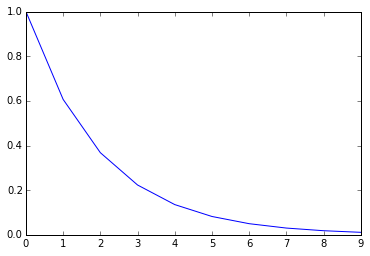

In [117]:
plt.plot(np.exp(-0.5 * np.arange(10)))

In [64]:
for cf in top_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 5))

In [65]:
a

array([4, 4, 2, 2, 8, 7, 1, 2, 0, 6])

In [67]:
np.argsort(-a)

array([4, 5, 9, 0, 1, 2, 3, 7, 6, 8])

In [ ]:
np.argosrt()

In [61]:
a = None

In [63]:
if a is None:
    print("ywe")

ywe


# Slashdot data set

In [127]:
data = pd.read_csv("../datasets/Slashdot0811.txt", sep='\t', header=4)
data = data.as_matrix()

In [128]:
data.shape

(905467, 2)

In [129]:
slashdot, user_item = make_valid_data(data)

In [137]:
list_cf = [
    rankingmethod.PopRec(user_item),
    rankingmethod.CLiMF(user_item, K=10, reg=0.001, lrate=0.01, verbose=0, maxiter=10),
    rankingmethod.BPR_MF(user_item, K = 20, lrate=0.001, regIpos=0.1, 
                              regIneg=0.1, regU=0.1, maxiter=30, verbose=0 ),
    rankingmethod.iMF(user_item, K=10, lmbd=0.01, alpha=40, maxiter=30, verbose=0),
    rankingmethod.TFMAP(user_item, lrate=0.01, maxiter=12)
    
]

list_measure = [
    rankingmeasure.get_prec_K,
    rankingmeasure.get_one_recal_K,
    rankingmeasure.get_MRR,
    rankingmeasure.get_AUC,
    rankingmeasure.get_NDCG,
    rankingmeasure.get_MAP
]

In [132]:
train, test, traintest = givenK_train_test(slashdot, 5)

In [133]:
poprec = rankingmethod.PopRec(user_item_slash)
poprec.fit(train)
top = poprec.get_list(0)[:3]
# all_measures(train, test, poprec, True, top)
all_measures(train, test, poprec, True)

precK 0.122225400458
1-call5 0.37528604118993136
MRR 0.273406086512
AUC 0.776325504811
NGDC 0.131158605935
MAP 0.227184043669


### givenk = 5

In [138]:
slash_ens = ensemble(list_cf, verbose=1)

In [139]:
slash_ens.fit(train)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4


In [140]:
for cf in slash_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 5))

[ 0.1222254   0.37528604  0.13115861  0.22718404]
[ 0.12233982  0.37585812  0.13122573  0.22734037]
[ 0.12268307  0.37585812  0.1314579   0.227249  ]
[ 0.10420481  0.33495423  0.10975777  0.19563589]
[ 0.12062357  0.37628719  0.12923841  0.22546283]


In [141]:
top_ens = top_ensemble(slash_ens.list_cf, topK=100)

In [142]:
rankingmeasure.get_Kmetrics(train, test, top_ens, True, K = 5)

array([ 0.12402746,  0.39487986,  0.13112244,  0.23042843])

### givenk = 10

In [144]:
train, test, traintest = givenK_train_test(slashdot, 10)

In [148]:
poprec = rankingmethod.PopRec(user_item)
poprec.fit(train)
top = poprec.get_list(0)[:3]
# all_measures(train, test, poprec, True, top)
all_measures(train, test, poprec, True)

precK 0.107236842105
1-call5 0.3433924485125858
MRR 0.257922316716
AUC 0.811548937839
NGDC 0.11728116847
MAP 0.212073321892


In [149]:
for cf in slash_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 5))

[ 0.11192792  0.3548341   0.12085361  0.21461968]
[ 0.11204233  0.35469108  0.12092646  0.21457261]
[ 0.11295767  0.35497712  0.12154309  0.21425399]
[ 0.17105263  0.55220252  0.18878241  0.35079178]
[ 0.11149886  0.3562643   0.11985853  0.21307586]


In [150]:
rankingmeasure.get_Kmetrics(train, test, top_ens, True, K = 5)

array([ 0.15946796,  0.51001144,  0.16663805,  0.29156159])

# старые эксперименты

In [ ]:
a = np.arange(10)
b = a[1:4]
print(a)
print(b)
b[2] = 100
a[1] = -a[1]
print(a)
print(b)

In [ ]:
tmp = mmread("../datasets/epinions_original/EP25_UPL5_test.mtx")
test = np.array(list(zip(tmp.row, tmp.col)))
tmp = mmread("../datasets/epinions_original/EP25_UPL5_train.mtx")
train = np.array(list(zip(tmp.row, tmp.col)))
user_item = [max(np.max(test[:,0]), np.max(train[:, 0])) + 1, max(np.max(test[:,1]), np.max(train[:,1])) + 1]

In [ ]:
train = create_listarray(train)
test  = create_listarray(test)

In [ ]:
create_csr(train, user_item, '../pyCLiMF-master/good_train.pickle')
create_csr(test, user_item, '../pyCLiMF-master/good_test.pickle')

In [ ]:
randomrec = rankingmethod.RandomRec(user_item)
randomrec.fit(train)
all_measures(train, test, randomrec, False)

In [ ]:
poprec = rankingmethod.PopRec(user_item)
poprec.fit(train)
top = poprec.get_list(0)[:3]
# all_measures(train, test, poprec, True, top)
# all_measures(train, test, poprec, True)

In [ ]:
rankingmeasure.get_AUC(train, test, poprec, True, K=user_item[1])

In [ ]:
rankingmeasure.get_NDCG(train, test, poprec, True, K = 5)

In [ ]:
rankingmeasure.get_NDCG(train, test, poprec, True, K = 3)

In [ ]:
index_user = np.random.choice(len(train), 100, replace=False)


In [ ]:
orig_train = create_original_sample(train, index_user)
orig_test = create_original_sample(test, index_user)

In [ ]:
climf = rankingmethod.CLiMF(user_item, lrate = 0.0001, reg=0.001, maxiter=15, verbose=2)
climf.fit(train)

In [ ]:
rankingmeasure.get_MRR(train, test, climf, True)

In [ ]:
all_measures(train, test, climf, True, top)

In [ ]:
all_measures(train, test, climf, True)

In [ ]:
climf = rankingmethod.CLiMF(user_item, maxiter=40, lrate = 0.1, verbose=2)
climf.fit(train)


In [ ]:
all_measures(train, test, climf, False)

In [ ]:
all_measures(train, test, climf, True, top)

In [ ]:
list_reg = [0.001, 0.002, 0.005, 0.0005]
list_lrate = [0.05, 0.07, 0.1, 0.12, 0.15 ]
list_K = [10, 12, 15, 7, 5]
times_count = 3

for K, lrate, reg in itertools.product(list_K, list_lrate, list_reg):
    MRR = 0
    
    for t in range(times_count):
        climf = rankingmethod.CLiMF(user_item,K=K, reg=reg, lrate=lrate, verbose=0, maxiter=50)
        climf.fit(train)
        MRR += rankingmeasure.get_MRR(train, test, climf, skip_train=False)
    print("K", K, "lrate", lrate, "reg", reg, "MRR", MRR/times_count)
    sys.stdout.flush()

In [ ]:
bpr_mf = rankingmethod.BPR_MF(user_item, K = 20, lrate=0.001, regIpos=0.1, 
                              regIneg=0.1, regU=0.1, maxiter=30, verbose=2 )

In [ ]:
bpr_mf.fit(train)

In [ ]:
all_measures(train, test, bpr_mf, True)

In [ ]:
rankingmeasure.get_AUC(train, test, bpr_mf, True, K=user_item[1])

In [ ]:
rankingmeasure.get_NDCG(train, test, bpr_mf, True, K=5)

In [ ]:
imf = rankingmethod.iMF(user_item, K=20, lmbd=0.01, alpha=40, maxiter=30, verbose=2)

In [ ]:
imf.fit(train)

In [ ]:
all_measures(train, test, imf, True)

In [ ]:
all_measures(train, test, imf, True, top)

In [ ]:
all_measures(train, test, bpr_mf, True, top)

In [ ]:
all_measures(train, test, poprec, True)

In [ ]:
all_measures(train, test, poprec, True, top)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
a = np.array([False,False, True, True])
b = np.array([0,2,1,3])
print(roc_auc_score(a, b, average=None))

In [ ]:
(a == True).any()

In [ ]:
import random

In [ ]:
random.sample(range(10), 3)